In [ ]:
%load_ext autoreload
%autoreload 2

In [122]:
np.array([[1, 2, 3, np.nan, 5]]).shape

(1, 5)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns

from qolmat.imputations.imputers import ImputerMICE, ImputerRegressor
from qolmat.imputations import estimators
from qolmat.benchmark.metrics import get_metric
from qolmat.benchmark import missing_patterns
from qolmat.benchmark import comparator
from qolmat.utils import plot
from qolmat.imputations import imputers
from qolmat.imputations.estimators import OneHotEncoderProjector

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.base import (
    BaseEstimator,
    ClassifierMixin,
    RegressorMixin,
)
from sklearn.compose import make_column_selector as selector

# from category_encoders.one_hot import OneHotEncoder

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
df = pd.read_csv("../data/titanic.csv", sep=";")

In [4]:
y = df["survived"] == 1

In [5]:
df = df.dropna(how="all")
df = df.drop(columns=["pclass", "survived", "name", "home.dest", "cabin", "ticket", "boat", "body"])

In [6]:
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["fare"] = pd.to_numeric(df["fare"].str.replace(",", ""), errors="coerce")

In [7]:
df.head(3)

,sex,age,sibsp,parch,fare,embarked
0,female,29.0,0.0,0.0,2113375.0,S
1,male,NaN,1.0,2.0,1515500.0,S
2,female,2.0,1.0,2.0,1515500.0,S


In [8]:
selector_cat = selector(dtype_exclude=np.number)
cols_cat = selector_cat(df)
selector_num = selector(dtype_include=np.number)
cols_num = selector_num(df)

In [10]:
imputer_rpca = imputers.ImputerRpcaNoisy()
ohe = OneHotEncoderProjector(handle_unknown="ignore", handle_missing="return_nan", use_cat_names=True, cols=cols_cat)
bt = estimators.BinTransformer(cols=cols_num)
wrapper = Pipeline(steps=[("OneHotEncoder", ohe), ("BinTransformer", bt)])

imputer_wrap_rpca = estimators.WrapperTransformer(imputer_rpca, wrapper)

In [11]:
ohe.mapping

In [12]:
df_imp = imputer_wrap_rpca.fit_transform(df.iloc[:100])

In [15]:
pipestimator = estimators.make_robust_MixteHGB(allow_new=False)
imputer_hgb = ImputerRegressor(estimator=pipestimator, handler_nan="none")
imputer_wrap_hgb = estimators.WrapperTransformer(imputer_hgb, bt)

In [16]:
imputer_simple = imputers.ImputerSimple()

In [17]:
dict_imputers = {"Simple": imputer_simple, "HGB": imputer_wrap_hgb, "RPCA": imputer_wrap_rpca}
cols_to_impute = df.columns
ratio_masked = .1
generator_holes = missing_patterns.UniformHoleGenerator(n_splits=2, subset=cols_to_impute, ratio_masked=ratio_masked, sample_proportional=False)
metrics = ["mae", "accuracy"]

In [61]:
comparison = comparator.Comparator(
    dict_imputers,
    cols_to_impute,
    generator_holes = generator_holes,
    metrics=metrics,
    max_evals=2,
)
results = comparison.compare(df)

Testing model: Simple...done.
Testing model: HGB...done.
Testing model: RPCA...done.


In [111]:
display(results.loc["mae"].style.highlight_min(color="lightgreen", axis=1))

,Simple,HGB,RPCA
age,10.935115,10.202290,11.278626
sibsp,0.427481,0.328244,0.446565
parch,0.297710,0.324427,0.393130
fare,254970.885496,285660.019084,244295.000000


In [112]:
display(results.loc["accuracy"].style.highlight_max(color="lightgreen", axis=1))

,Simple,HGB,RPCA
sex,0.648855,0.652672,0.606870
age,0.026718,0.041985,0.026718
sibsp,0.706107,0.721374,0.687023
parch,0.805344,0.763359,0.736641
fare,0.003817,0.000000,0.000000
embarked,0.633588,0.797710,0.713740


# Imputation analysis

In [113]:
mask = generator_holes.generate_mask(df)
df_corr = df.where(~mask, np.nan)
df_imp = imputer_wrap_hgb.fit_transform(df_corr)

In [114]:
ages = df[mask]["age"]
ages_imp = df_imp[mask]["age"]

In [115]:
mesh = np.arange(ages.max() + 1)
counts = ages.value_counts().reindex(mesh, fill_value=0)
counts_imp = ages_imp.value_counts().reindex(mesh, fill_value=0)

In [116]:
pd.concat([counts, counts_imp], axis=1)

,count,count
age,,
0.0,0,0
1.0,2,0
2.0,1,0
3.0,0,0
4.0,2,0
...,...,...
76.0,0,0
77.0,0,0
78.0,0,0


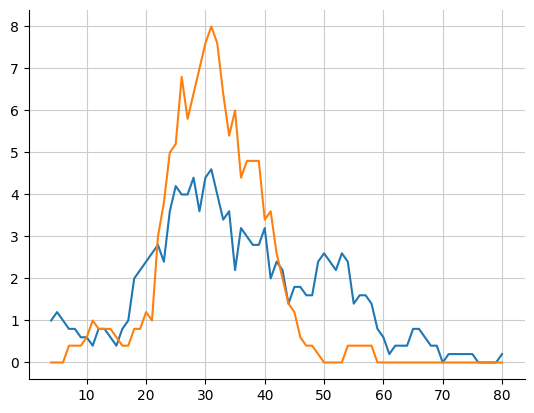

In [117]:
plt.plot(counts.rolling(5).mean())
plt.plot(counts_imp.rolling(5).mean())

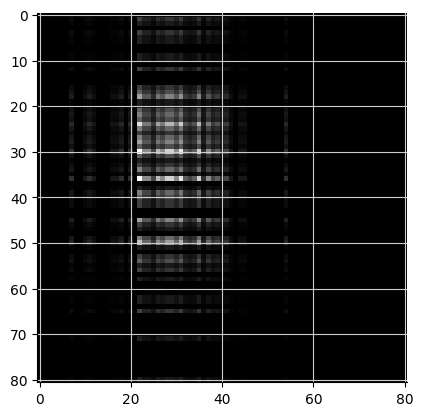

In [120]:
plt.imshow(counts.to_frame() @ counts_imp.to_frame().T, cmap="gray")